Alexander S. Lundervold, 29.04.22

# Introduction

The concept of _representations_ is core to deep learning. As we've seen, deep learning models are **representation learners**, automatically constructing _task-specific representations_ for a given task. 

In the next notebook, we'll look at how one can _extract_ these representations. 

But another way representations enter the game is on the input side: one must also think about how to best represent your data and task. Whether changing the representations before feeding data to a neural network can provide new insights and results. 

To make this more concrete, let's do a simple example. 

## Changing input representations

When faced with a predictive task based on non-imaging data, an approach that has seen some success in some instances and is therefore worth knowing about and considering is finding a way to **represent your data as images**. 

This makes it possible to use the relatively well-developed image analysis techniques in deep learning, f.ex. the landscape surrounding convolutional neural networks. 

Of course, this clearly won't make sense in _all_ cases. It can be challenging--or impossible--to capture the information needed to make useful predictions in an image representation in a way that's adapted to the image-based predictive models you'll want to use. 

Still, there are examples of this leading to good results:

An approach to **sound classification**, as used f.ex. for speech recognition, is based on turning audio into _spectrograms_, e.g. using mel spectrograms to represent speech: 

<img width=60% src="assets/melspecs.png">

[Catching fraudsters using their mouse movements](https://www.splunk.com/en_us/blog/security/deep-learning-with-splunk-and-tensorflow-for-security-catching-the-fraudster-in-neural-networks-with-behavioral-biometrics.html) is another interesting example. So is [malware classification](https://ieeexplore.ieee.org/abstract/document/8328749). 

An example of the more general idea of representing **time series data to image data** can be found in one of our (ongoing) works, where we represent **longitudinal measurements** recorded from multiple subjects as greyscale images, one per subject:

<img width=70% src="assets/long_images1.png">

<img src="assets/long_images2.png">

This notebook illustrates the approach on another type of data and problem: small molecules and **prediction of bioactivity for given targets**, a core component of **drug discovery**.

This idea is currently being explored in our DLN research project [Respond3](https://www.digitallifenorway.org/research/respond3/index.html).

<a href="https://www.digitallifenorway.org/research/respond3/index.html"><img width=80% src="assets/respond3.png"></a>

> In this notebook we use the image representations of the data sets in https://link.springer.com/article/10.1186/s13321-017-0226-y as created in `1.0-representations-get_molecular_fingerprints_and_images.ipynb`. To successfully run this notebook you'll have to first run the notebook linked above. It'll download the raw data and prepare the images.

<img width=60% src="assets/MOESM-paper.png">

The goal is to predict the activity of various ligands (small molecules) against a set of seven target classes. In other words, approximate some kind of function

$$\Phi = f(C),$$

where $\Phi$ is the activity and $C$ is the chemical structure of the ligand. This is part of what's called [QSAR](https://en.wikipedia.org/wiki/Quantitative_structure%E2%80%93activity_relationship), Quantitative structure-activity relationship.

1. CHEMBL205: Carbonic Anhydrase II, a protein lyase
2. CHEMBL301: Cyclin-dependent kinase 2, a protein kinase
3. CHEMNL240: ether-a-go-go-related gene potassium channel 1 (HERG)
4. CHEMBL219: Dopamine D4 receptor, a monoamine GPCR
5. CHEMBL244: Coagulation factor X, a serine protease
6. CHEMBL218: Cannabinoid CB1 receptor, a lipid-like GPCR
7. CHEMBL1978: Cytochrome P450 19A1, a cytochrome P450

**Note:**

> In this notebook we use the image representations of the data sets in https://link.springer.com/article/10.1186/s13321-017-0226-y as created in `1.0-representations-get_molecular_fingerprints_and_images.ipynb`. To successfully run this notebook you'll have to first run the notebook linked above. It'll download the raw data and prepare the images.

# Setup

In [ ]:
chembl_to_dataset = {
    
    'CHEMBL205': 'CAII',
    'CHEMBL301': 'CDK2',
    'CHEMBL240': 'HERG',
    'CHEMBL219': 'DRD4',
    'CHEMBL244': 'CogX',
    'CHEMBL218': 'CB1',
    'CHEMBL1978': 'CYP_19A1'}

In [ ]:
top_mcc_scores = {
    
    'CHEMBL205': 0.862,
    'CHEMBL301': 0.926,
    'CHEMBL240': 0.884,
    'CHEMBL219': 0.887,
    'CHEMBL244': 0.983,
    'CHEMBL218': 0.941,
    'CHEMBL1978': 0.904}

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd
import gc

In [ ]:
%reload_ext autoreload 
%autoreload 2

# Jedi not working
%config Completer.use_jedi = False

In [ ]:
NB_DIR = Path.cwd()

DATA = NB_DIR/'data'/'drug'
RAWDATA = DATA/'raw'
INTERIMDATA = DATA/'interim'

# Path to image data as defined earlier
IMGDATA = Path('/data2/drugdiscovery/MOESM/molimages/')

In [ ]:
from fastai.vision.all import *

# Load data

In [ ]:
# Datasets available:
ds = sorted(list(RAWDATA.glob('CHEM*cl.csv')))

In [ ]:
ds

In [ ]:
IMGDATA.ls()

In [ ]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    name = data.stem
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df, name

In [ ]:
def explore_dataset(data, plot=False):

    df, name = get_df(data)
    decoys, actives = df['Activity'].value_counts()
    data_name = chembl_to_dataset[name.split("_")[0]]
    score = top_mcc_scores[name.split("_")[0]]
    
    
    print(f"Data set is {name}, {data_name}")
    print(f"MCC top score was {score}")
    print(f"It consists of {len(df)} molecules")
    print(f"There are {decoys} decoys and {actives} actives")
    if plot:
        dls = ImageDataLoaders.from_df(df, path=IMGDATA/name, label_col='Activity', fn_col='Image', bs=32)
        dls.show_batch(nrows=2, ncols=2, max_n=32)
        plt.show()
        # Free up GPU memory after plotting:
        dls=None
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
explore_dataset(ds[0], plot=True)

In [ ]:
for data in ds:
    explore_dataset(data, plot=False)
    print("#"*40)
    print()

In [ ]:
df, name = get_df(ds[0])

In [ ]:
name

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df['Activity'].value_counts()

# Create train-val-split and oversample train

> **TMP:** Oversampling active molecules by duplicating in data frame. Fix: better do it by weights in the dataloader, to save compute and memory.

In [ ]:
df, name = get_df(ds[0])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df

# Create dataloader

In [ ]:
def get_dataloader(dataset, oversample=False, random_state=42, test_size=0.25, 
                   bs=64, batch_tfms=None):
    
    
    # Get the data set as a df, and also the name
    df, name = get_df(dataset)
    
    print(f"Creating a dataloader for the dataset {name}")
    print(f"Settings: oversample={oversample}, random_state={random_state}, test_size={test_size}, batch size={bs}")
    
    # Create is_valid column and oversample
    df = val_cols_and_oversample(df, oversample=oversample, 
                                 test_size=test_size, random_state=random_state)
    
    # Create a datablock
    datablock = DataBlock(
        blocks=(ImageBlock(), CategoryBlock()),
        get_x=ColReader('Image', pref=IMGDATA/name),
        get_y=ColReader('Activity'),
        splitter=ColSplitter('is_valid'),
        item_tfms=None,
        batch_tfms=batch_tfms
        )
    
    # Create a dataloader
    dl = datablock.dataloaders(df, bs=bs, shuffle_train=True)
    
    print("DONE")
    return dl

For data augmentation, we rotate the images slightly. We also normalize them to have the same intensity stats as the images in the ImageNet data set. This is because we'll use models pretrained on ImageNet data:

In [ ]:
batch_tfms = [Rotate(max_deg=25, pad_mode='border'), 
              Normalize.from_stats(*imagenet_stats)]

In [ ]:
dl = get_dataloader(ds[0], 
                    oversample=True, 
                    random_state=42,
                    batch_tfms=batch_tfms)

In [ ]:
dl.show_batch()

One should always have a look at the transformations performed for data augmentation. Figuring out which transformations makes sense, and which doesn't, can sometimes be difficult, requiring domain knowledge. In a given situation one may also come up with novel, tailor-made transformations. 

Data augmentation is both a way to expand the training data set (as long as the labels on the transformed data stays the same as the original), and a way to make the model more invariant to the defined transformations. 

In [ ]:
dl.show_batch(unique=True)

> **Tip:** There are libraries that can help with data augmentation. For images, the `albumentations` library is worth a look: https://github.com/albumentations-team/albumentations. We'll discuss the ecosystem of libraries in deep learning later. 

# Train

In [ ]:
from utils import plot_metrics

In [ ]:
def train_model(dl, arch=resnet18, pretrained=True, epochs=10, wd=2e-4, ps=0.8, train=True):
    
    print(f"Training a model on the provided data\n")
    print(f"### Architecture: arch={arch} ###")
    print(f"\t pretrained={pretrained}, epochs={epochs}\n")
    print(f"### Regularization: weight decay={wd}, droput rate={ps} ### \n")
    
    # Create learner
    learn = cnn_learner(
        dl,                             
        arch=arch, pretrained=pretrained,   
        wd=wd, ps=ps,                       
        metrics=[accuracy,                  
                 F1Score(), 
                 Precision(), 
                 Recall(), 
                 RocAucBinary(), 
                 MatthewsCorrCoef()],
        cbs=[ShowGraphCallback()])
    
    if not train:
        return learn
    
    print(f"Finding a learning rate...")
    lr = learn.lr_find(show_plot=False)
    
    print(f"Using the base learning rate lr_steep={lr.valley}\n")
    
    print(f"### Training the model... ### \n")
    
    learn.fit_one_cycle(epochs, slice(lr.valley))
    
    return learn

## Train on a sample data set: `CHEMBL1978`

In [ ]:
ds[0]

In [ ]:
dl = get_dataloader(ds[0], 
                    oversample=True, 
                    random_state=42,
                    batch_tfms=batch_tfms)

In [ ]:
learn = train_model(dl, train=False)
learn = learn.load('chembl1978-model')

Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7ff0aefb33a0> ###
	 pretrained=True, epochs=15

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_steep=0.002511886414140463

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.087495,0.375075,0.843091,0.496241,0.350133,0.851613,0.932817,0.480573,00:36
1,0.583560,0.273193,0.889344,0.595289,0.445513,0.896774,0.955969,0.583861,00:36
2,0.365986,0.192709,0.915691,0.658768,0.520599,0.896774,0.968618,0.644135,00:36
3,0.296734,0.192719,0.932084,0.715686,0.577075,0.941935,0.976142,0.705980,00:36
4,0.243797,0.168013,0.939696,0.740554,0.607438,0.948387,0.975390,0.730812,00:36
5,0.218375,0.132000,0.954918,0.785515,0.691176,0.909677,0.974725,0.769817,00:36
6,0.197345,0.150352,0.950234,0.773333,0.659091,0.935484,0.976142,0.760774,00:36
7,0.181911,0.133269,0.961944,0.811594,0.736842,0.903226,0.977313,0.795742,00:36
8,0.138276,0.139961,0.956674,0.793296,0.699507,0.916129,0.977974,0.778325,00:36
9,0.148651,0.114181,0.963115,0.817391,0.742105,0.909677,0.980446,0.802224,00:36


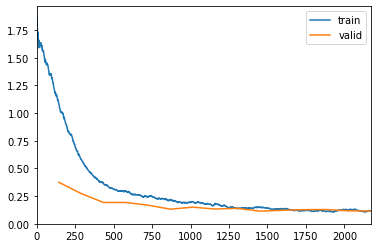

In [48]:
#learn = train_model(dl, epochs=15)

Plotting the performance on the validation set using the given metrics is useful. Remember that its the metrics you care about the most (often/ideally you're optimizing a single metric). In our case, that could be the Matthew's correlation coefficient:

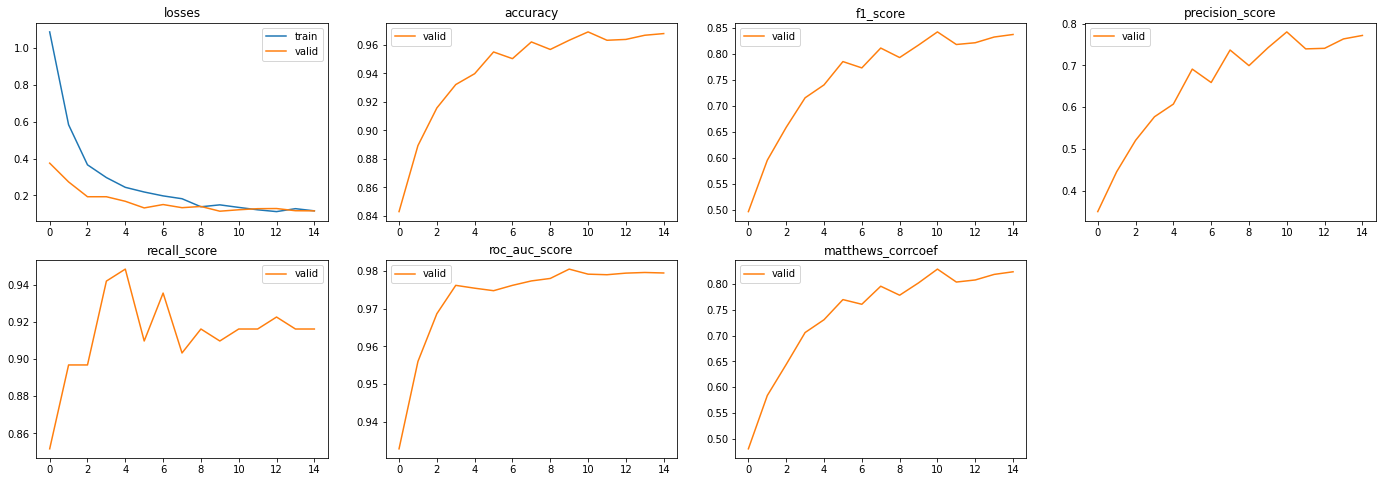

In [49]:
learn.recorder.plot_metrics()

In [50]:
#learn.save('chembl1978-model')

Path('models/chembl1978-model.pth')

## Interpretation

Here are a few predictions and labels:

In [ ]:
learn.show_results()

How many mistakes did the model make? Of what kind?

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

On what images was it the most wrong in terms of high confidence in wrong predictions? 

In [90]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

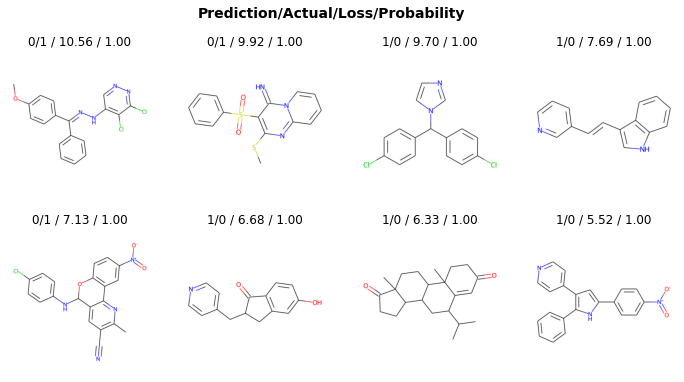

In [91]:
plot_top_losses_fix(interp, k=8)

In many cases, inspection of cases where the model was the most wrong can be extremely useful during model development. 

## Class activation maps

Using _class activation maps_ we can get an impression of what features the model used to make its predictions:

In [93]:
img, c = dl.valid_ds[0]

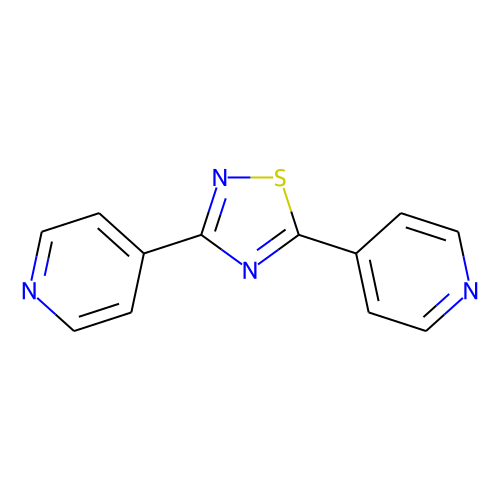

In [94]:
img

In [95]:
from utils import gradcam

/home/ubuntu/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/home/ubuntu/anaconda3/envs/fastai/lib/python3.8/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a cust

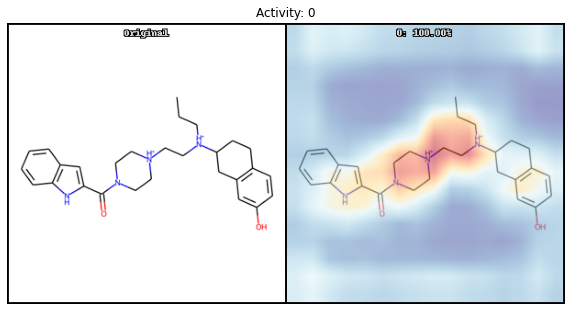

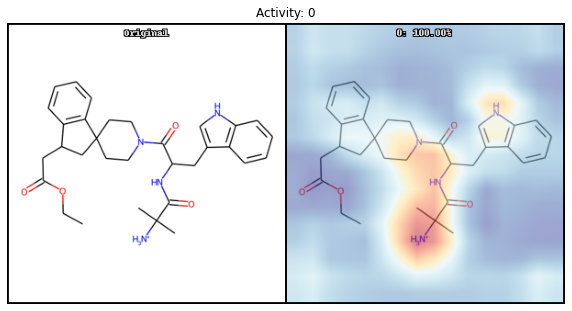

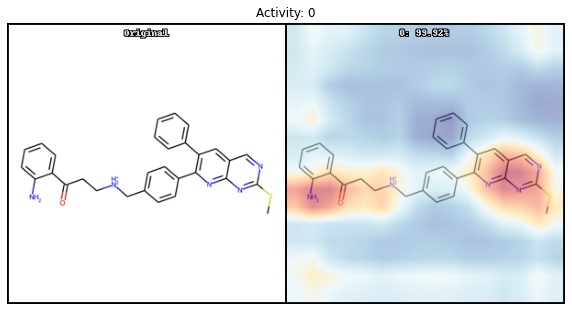

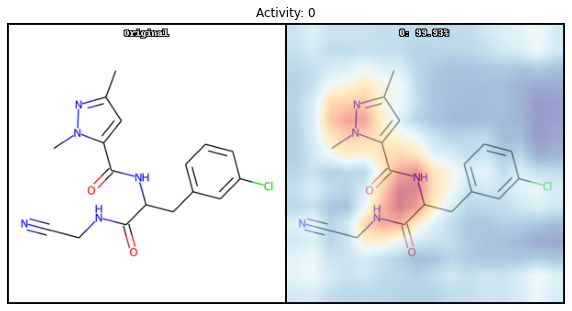

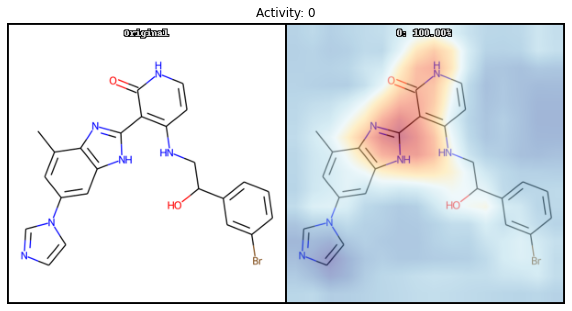

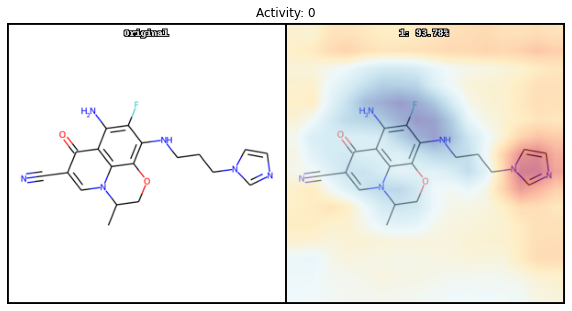

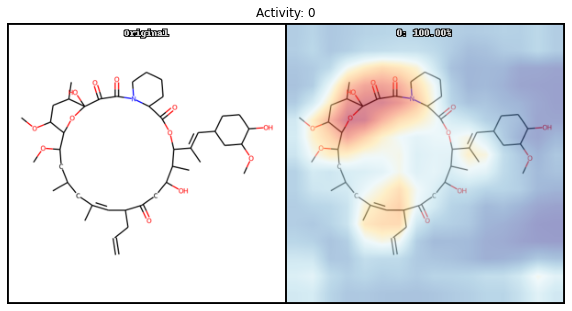

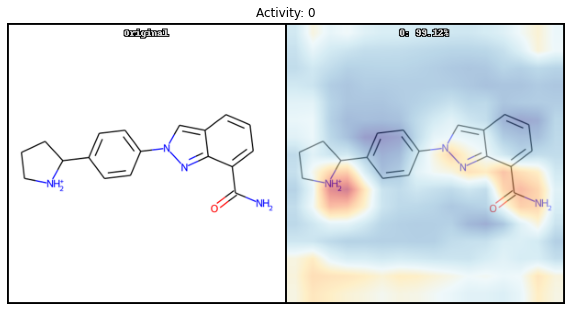

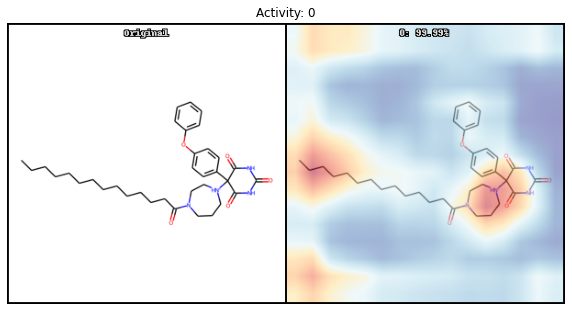

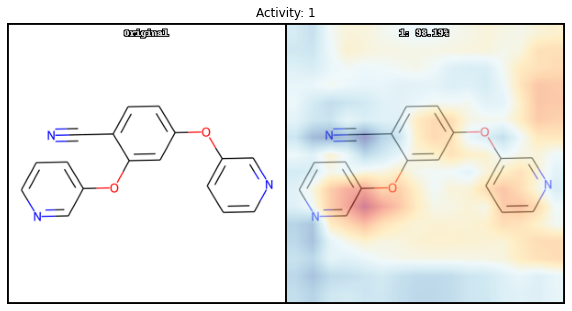

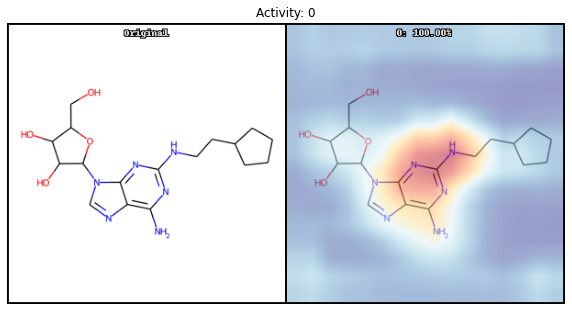

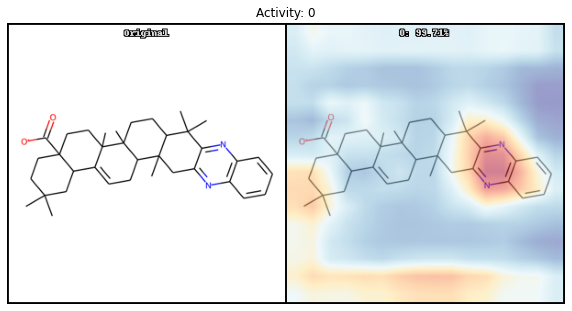

In [96]:
for img in random.choices(dl.valid_ds, k=12):
    gcam = gradcam(learn, img[0], show_original=True)
    f = plt.figure(figsize=(10,8))
    plt.imshow(gcam)
    plt.title(f"Activity: {img[1]}")
    plt.axis('off')
    plt.show()

The way the model seems to sometimes use information from outside the actual molecule is an indication that there is some _data leakage_ in the way the problem has been set up. I.e. that there's information in the images that relates to activity but that potentially isn't in the actual molecular structure. 

# Train models on all the data

We'll now train models for each of the seven data sets. We'll also train them slightly longer than before. This therefore takes a while...

Training a resnet18 model on CHEMBL1978
Top score in the paper was 0.904

Creating a dataloader for the dataset CHEMBL1978_cl
Settings: oversample=True, random_state=42, test_size=0.25, batch size=64
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f2ea4d2cc10> ###
	 pretrained=True, epochs=20

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.014454397559165954

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.632174,0.270685,0.889344,0.597015,0.445860,0.903226,0.956928,0.586723,00:38
1,0.377553,0.163017,0.938525,0.727273,0.608696,0.903226,0.969553,0.711292,00:38
2,0.355966,0.175594,0.945550,0.752000,0.640909,0.909677,0.973982,0.736436,00:38
3,0.350414,0.390720,0.902810,0.634361,0.481605,0.929032,0.971485,0.626806,00:38
4,0.250508,0.209553,0.949063,0.768000,0.654545,0.929032,0.978084,0.754689,00:38
5,0.216296,0.196776,0.951405,0.772603,0.671429,0.909677,0.975826,0.756879,00:38
6,0.181136,0.152283,0.966042,0.819876,0.790419,0.851613,0.978219,0.801837,00:38
7,0.168657,0.139863,0.973068,0.856250,0.830303,0.883871,0.980061,0.841909,00:38
8,0.137909,0.125283,0.971311,0.848297,0.815476,0.883871,0.978504,0.833307,00:38
9,0.123130,0.127608,0.968384,0.831250,0.806061,0.858065,0.980915,0.814311,00:39


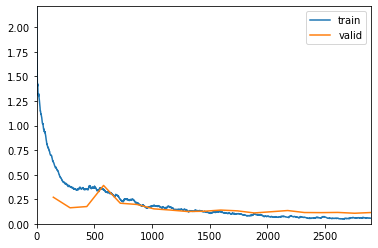

########################################



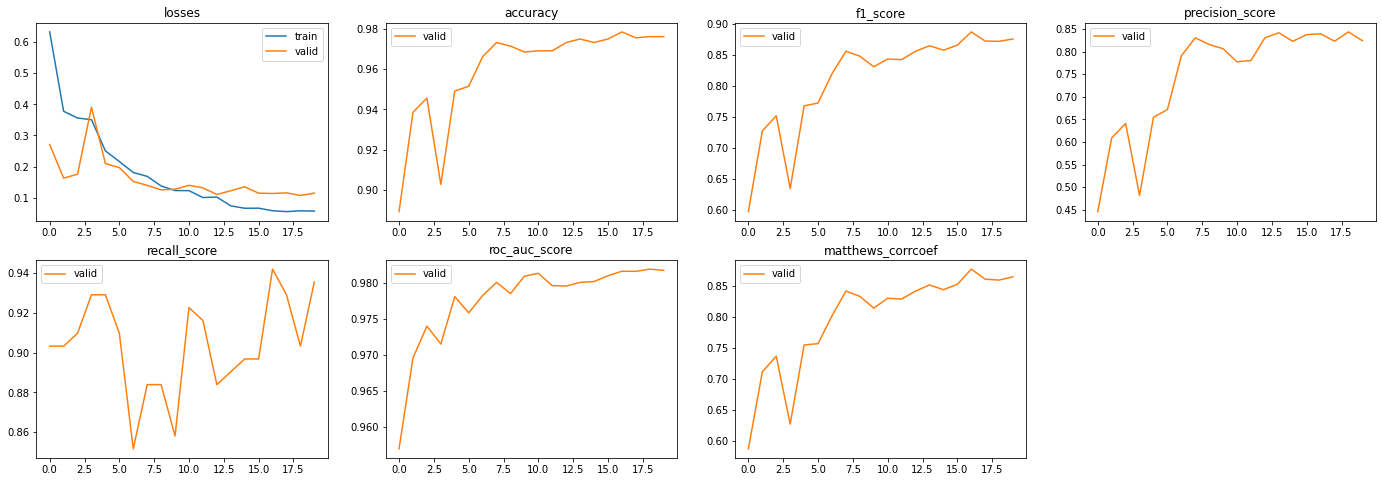

########################################


Training a resnet18 model on CHEMBL205
Top score in the paper was 0.862

Creating a dataloader for the dataset CHEMBL205_cl
Settings: oversample=True, random_state=42, test_size=0.25, batch size=64
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f2ea4d2cc10> ###
	 pretrained=True, epochs=20

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.010000000149011612

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.437196,0.273642,0.895230,0.617264,0.462195,0.928922,0.963700,0.610629,01:35
1,0.317880,0.237047,0.910388,0.655232,0.503958,0.936275,0.972903,0.647681,01:35
2,0.293967,0.228201,0.931788,0.713483,0.577273,0.933824,0.978171,0.702474,01:35
3,0.270409,0.215322,0.928890,0.708143,0.564964,0.948529,0.980349,0.699831,01:35
4,0.199948,0.200830,0.939367,0.741935,0.605263,0.958333,0.983014,0.733642,01:35
5,0.175325,0.126964,0.961436,0.816543,0.719626,0.943627,0.983015,0.804556,01:35
6,0.158762,0.158491,0.952073,0.781726,0.667244,0.943627,0.983002,0.770026,01:35
7,0.160307,0.180304,0.949175,0.775148,0.648515,0.963235,0.983432,0.766340,01:35
8,0.132420,0.154234,0.961658,0.818565,0.718519,0.950980,0.984352,0.807394,01:35
9,0.137316,0.137559,0.958983,0.807531,0.704380,0.946078,0.984025,0.795835,01:35


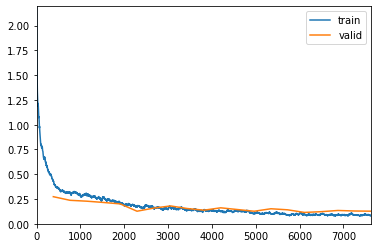

########################################



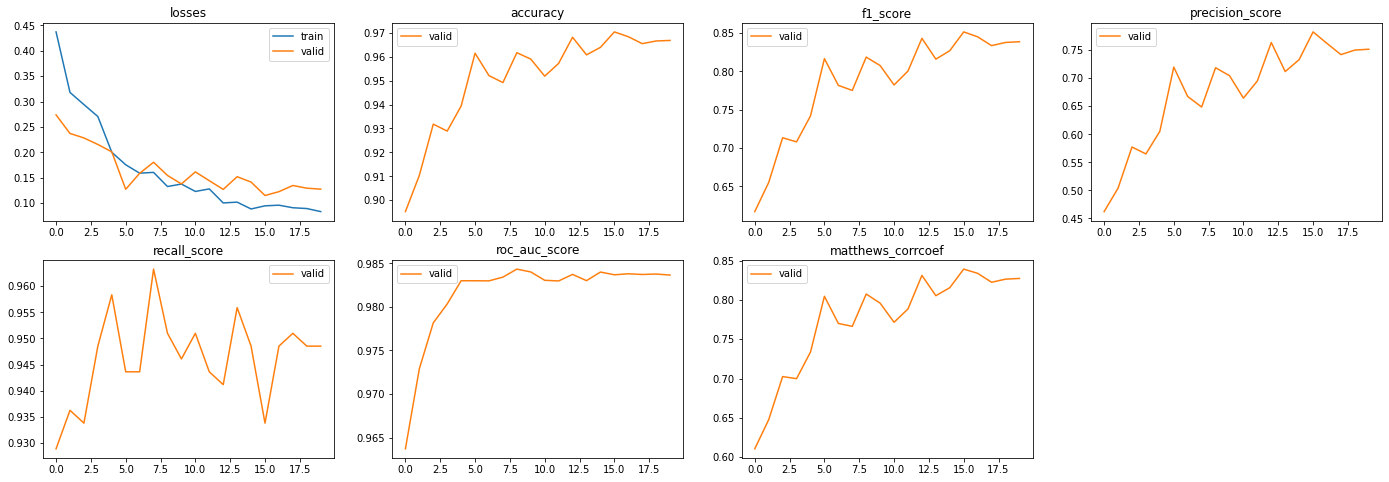

########################################


Training a resnet18 model on CHEMBL218
Top score in the paper was 0.941

Creating a dataloader for the dataset CHEMBL218_cl
Settings: oversample=True, random_state=42, test_size=0.25, batch size=64
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f2ea4d2cc10> ###
	 pretrained=True, epochs=20

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.006918309628963471

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.565880,0.362829,0.845154,0.508495,0.358120,0.876569,0.934798,0.496882,01:50
1,0.388302,0.309633,0.868285,0.559181,0.402765,0.914226,0.958392,0.552824,01:50
2,0.341536,0.311849,0.869432,0.566349,0.406563,0.933054,0.963572,0.563470,01:50
3,0.288609,0.183847,0.930797,0.706645,0.576720,0.912134,0.977958,0.692307,01:50
4,0.232680,0.273764,0.897534,0.625698,0.469602,0.937238,0.976456,0.619926,01:50
5,0.187377,0.118803,0.954693,0.785131,0.692800,0.905858,0.983907,0.768854,01:50
6,0.160788,0.119513,0.954502,0.783242,0.693548,0.899582,0.984632,0.766310,01:50
7,0.159903,0.137699,0.948193,0.770533,0.647226,0.951883,0.987365,0.760094,01:50
8,0.152630,0.096222,0.963869,0.824513,0.741235,0.928870,0.989067,0.811024,01:50
9,0.134679,0.099005,0.963487,0.824931,0.734095,0.941423,0.990126,0.812661,01:50


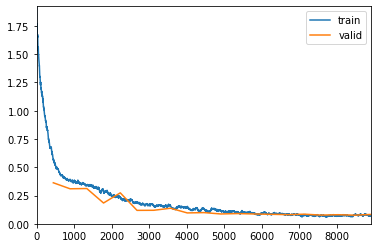

########################################



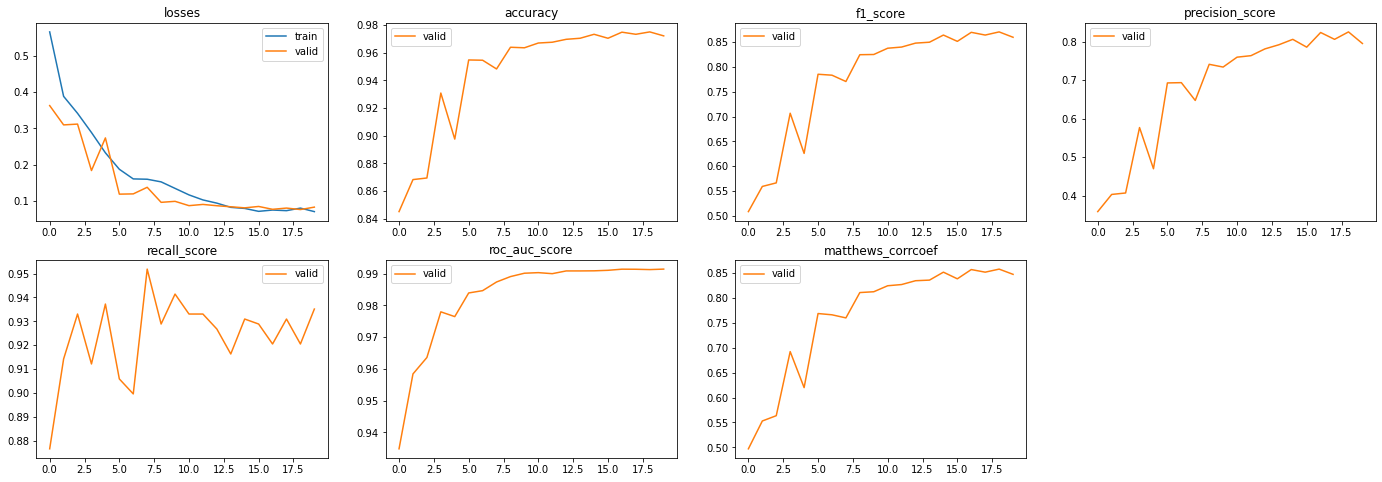

########################################


Training a resnet18 model on CHEMBL219
Top score in the paper was 0.887

Creating a dataloader for the dataset CHEMBL219_cl
Settings: oversample=True, random_state=42, test_size=0.25, batch size=64
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f2ea4d2cc10> ###
	 pretrained=True, epochs=20

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.012022644281387329

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.775888,0.387645,0.863506,0.543269,0.391003,0.889764,0.929445,0.532891,00:32
1,0.463114,0.282721,0.889368,0.590426,0.445783,0.874016,0.945436,0.574703,00:32
2,0.402293,0.212905,0.933190,0.680412,0.603659,0.779528,0.941975,0.650344,00:32
3,0.416462,0.339857,0.890805,0.595745,0.449799,0.881890,0.951424,0.581212,00:32
4,0.354782,0.347317,0.886494,0.588542,0.439689,0.889764,0.953858,0.575844,00:32
5,0.294491,0.235043,0.922414,0.676647,0.545894,0.889764,0.966257,0.659938,00:32
6,0.232886,0.210812,0.931753,0.705882,0.581633,0.897638,0.968025,0.689449,00:32
7,0.204694,0.279364,0.917385,0.664723,0.527778,0.897638,0.969431,0.649743,00:32
8,0.194214,0.218710,0.933908,0.708861,0.592593,0.881890,0.969923,0.690140,00:32
9,0.170027,0.183142,0.950431,0.767677,0.670588,0.897638,0.972326,0.750454,00:32


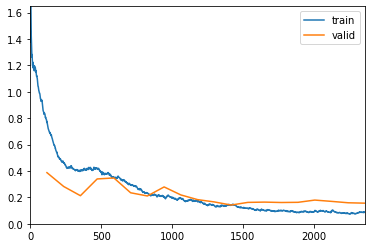

########################################



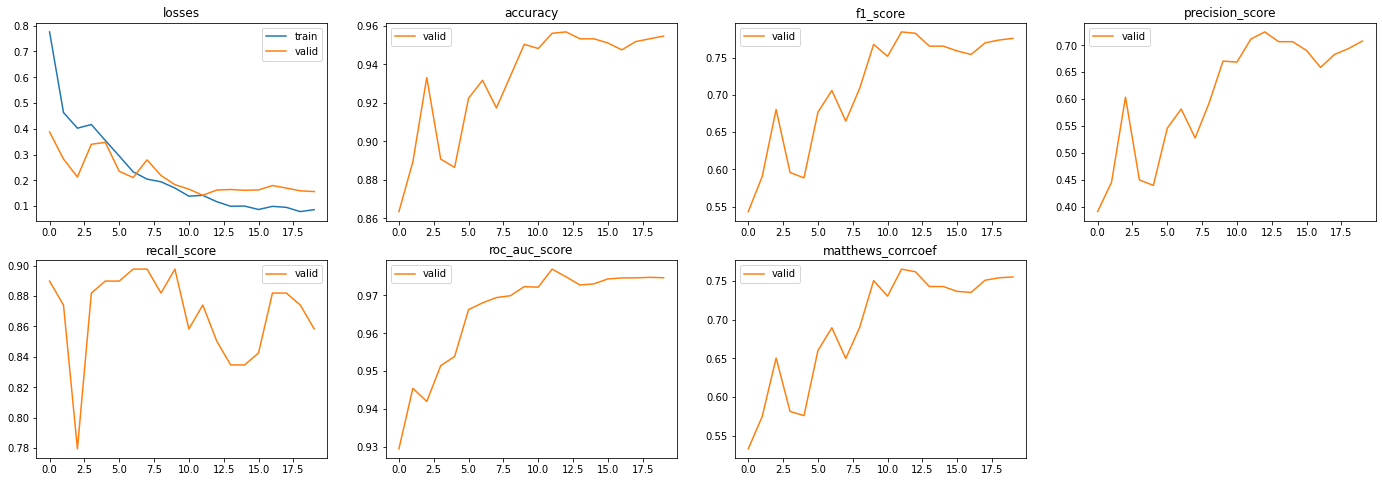

########################################


Training a resnet18 model on CHEMBL240
Top score in the paper was 0.884

Creating a dataloader for the dataset CHEMBL240_cl
Settings: oversample=True, random_state=42, test_size=0.25, batch size=64
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f2ea4d2cc10> ###
	 pretrained=True, epochs=20

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.005754399299621582

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.055578,0.461319,0.814545,0.444790,0.305556,0.817143,0.882919,0.423165,00:43
1,0.597553,0.344809,0.843117,0.484642,0.345499,0.811429,0.905166,0.461415,00:43
2,0.482342,0.361252,0.831169,0.469821,0.328767,0.822857,0.912705,0.449047,00:43
3,0.464925,0.397966,0.820260,0.469325,0.320755,0.874286,0.921567,0.458885,00:43
4,0.426399,0.247894,0.896623,0.596349,0.462264,0.840000,0.934122,0.574629,00:43
5,0.365222,0.212059,0.917922,0.644144,0.531599,0.817143,0.938158,0.617833,00:43
6,0.301360,0.194501,0.923636,0.660508,0.554264,0.817143,0.949600,0.634086,00:43
7,0.285807,0.178625,0.936623,0.700980,0.613734,0.817143,0.953574,0.674880,00:43
8,0.249834,0.161325,0.936623,0.698020,0.615721,0.805714,0.957313,0.670812,00:43
9,0.228090,0.186167,0.929870,0.680851,0.580645,0.822857,0.958495,0.655110,00:43


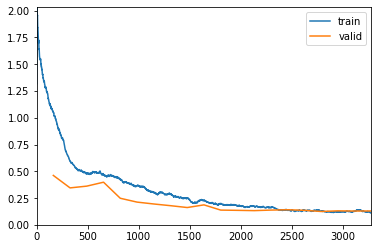

########################################



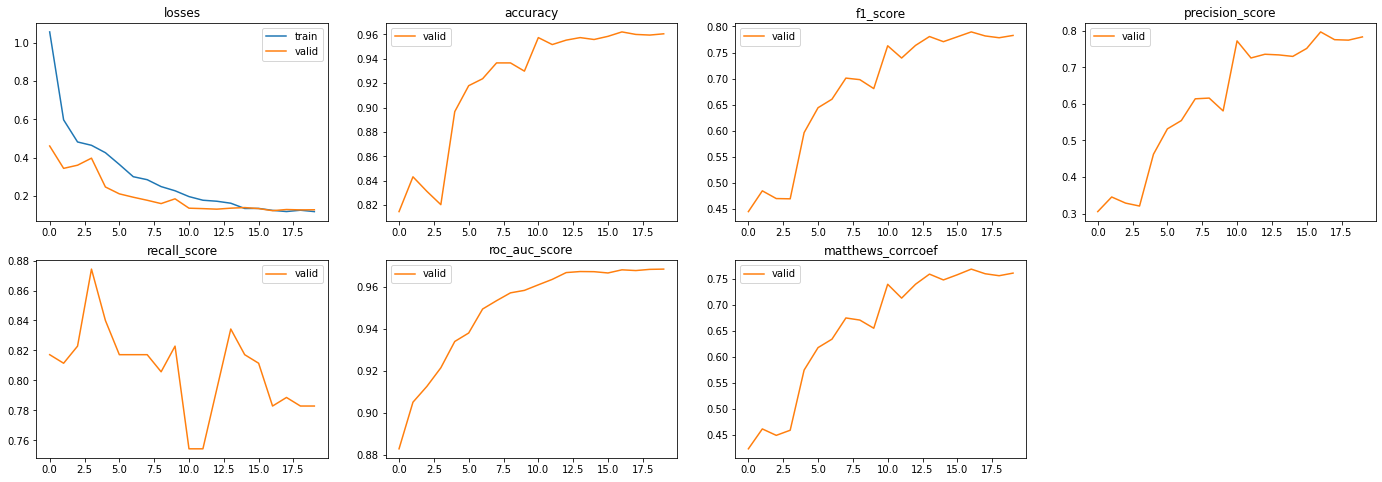

########################################


Training a resnet18 model on CHEMBL244
Top score in the paper was 0.983

Creating a dataloader for the dataset CHEMBL244_cl
Settings: oversample=True, random_state=42, test_size=0.25, batch size=64
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f2ea4d2cc10> ###
	 pretrained=True, epochs=20

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.014454397559165954

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.486732,0.255644,0.895105,0.602410,0.459559,0.874126,0.955237,0.586344,01:08
1,0.354751,0.209457,0.917355,0.655172,0.527778,0.863636,0.961873,0.635274,01:08
2,0.289784,0.349940,0.891926,0.615385,0.454849,0.951049,0.978757,0.613301,01:08
3,0.236661,0.132260,0.959313,0.803681,0.715847,0.916084,0.985606,0.788765,01:08
4,0.179846,0.112168,0.962492,0.820669,0.725806,0.944056,0.991022,0.808750,01:08
5,0.143257,0.112504,0.957406,0.804094,0.690955,0.961538,0.992687,0.794347,01:08
6,0.119843,0.072595,0.982835,0.901099,0.946154,0.860140,0.993662,0.892939,01:08
7,0.106552,0.069261,0.977114,0.882736,0.826220,0.947552,0.994955,0.872629,01:08
8,0.095149,0.118642,0.962492,0.823881,0.718750,0.965035,0.994537,0.814322,01:08
9,0.073294,0.058228,0.983789,0.910995,0.909408,0.912587,0.994565,0.902079,01:08


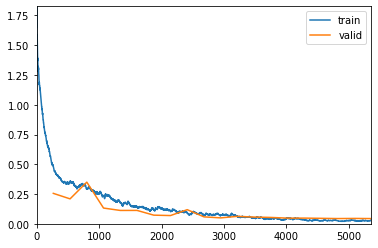

########################################



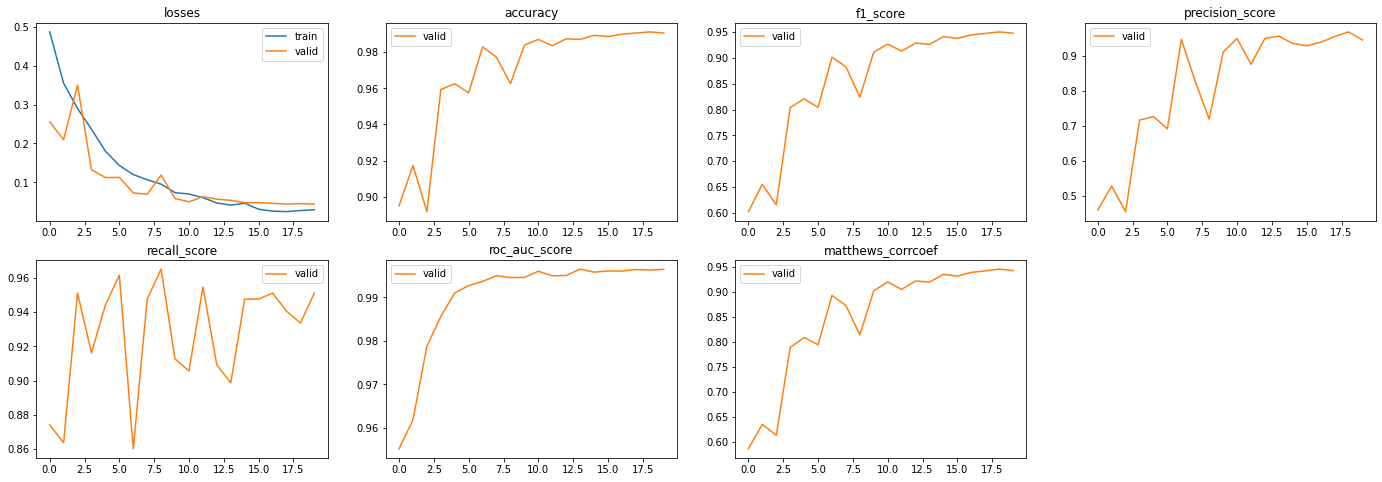

########################################


Training a resnet18 model on CHEMBL301
Top score in the paper was 0.926

Creating a dataloader for the dataset CHEMBL301_cl
Settings: oversample=True, random_state=42, test_size=0.25, batch size=64
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f2ea4d2cc10> ###
	 pretrained=True, epochs=20

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.003981071710586548

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.109992,0.579620,0.773595,0.396149,0.261343,0.818182,0.874214,0.374103,00:43
1,0.666578,0.419955,0.798865,0.428152,0.288538,0.829545,0.905913,0.409078,00:43
2,0.475509,0.308037,0.858174,0.500907,0.368000,0.784091,0.911608,0.472536,00:43
3,0.437332,0.309606,0.859721,0.505455,0.371658,0.789773,0.919307,0.477979,00:43
4,0.406352,0.234450,0.894791,0.571429,0.453333,0.772727,0.934045,0.539948,00:43
5,0.347514,0.241887,0.891697,0.581673,0.447853,0.829545,0.944983,0.558802,00:43
6,0.329248,0.339615,0.850438,0.521452,0.367442,0.897727,0.950833,0.514106,00:44
7,0.286376,0.176925,0.923672,0.662100,0.553435,0.823864,0.962335,0.636572,00:43
8,0.246995,0.162025,0.932439,0.673317,0.600000,0.767045,0.958161,0.642239,00:43
9,0.232516,0.186500,0.919546,0.651786,0.536765,0.829545,0.964008,0.627109,00:43


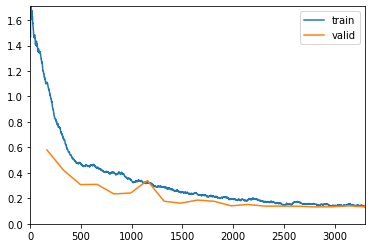

########################################



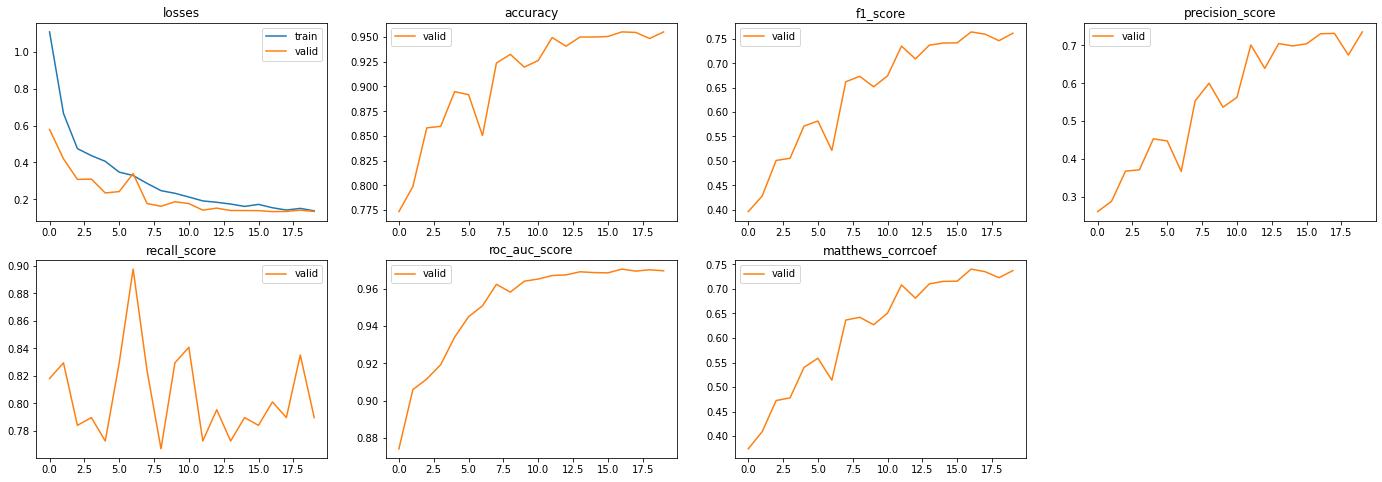

########################################




In [158]:
models = []
for data in ds: 
    name = str(data).split('/')[-1].split("_")[0]
    print(f"Training a resnet18 model on {name}")
    print(f"Top score in the paper was {top_mcc_scores[name]}")
    print()
          
    dl = get_dataloader(data, oversample=True, bs=64, batch_tfms=batch_tfms)
    learn = train_model(dl, epochs=20)
    models.append(learn)
    print("#"*40)
    print()
    learn.recorder.plot_metrics()
    print("#"*40)
    print()
    print()

# Extra: Test the effect of varying the validation set

> How sensitive are the results to the specific random selection of validation data?

If sensitive, one should do **k-fold cross-validation** rather than the hold-out validation above. At the cost of increased training time...

Training a resnet18 model with random state 1 when sampling validation data. 25 epochs:
Creating a dataloader for the dataset CHEMBL1978_cl
Settings: oversample=False, random_state=1, test_size=0.2
Settings: batch size=64, batch_tfms=None, item_tfms=None, image size=None
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f696c8ca430> ###
	 pretrained=True, epochs=25

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.017378008365631102

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.079030,0.262488,0.904170,0.573290,0.480874,0.709677,0.918239,0.534097,00:21
1,0.483070,0.179327,0.932699,0.520833,0.735294,0.403226,0.907508,0.513514,00:21
2,0.303903,0.164998,0.941478,0.615385,0.761905,0.516129,0.939078,0.597995,00:21
3,0.310852,0.197495,0.948793,0.672897,0.800000,0.580645,0.946851,0.655650,00:21
4,0.324957,0.210048,0.944404,0.724638,0.657895,0.806452,0.967275,0.698523,00:21
5,0.315323,0.258927,0.935625,0.536842,0.772727,0.411290,0.953332,0.534873,00:21
6,0.256169,0.199353,0.955377,0.738197,0.788991,0.693548,0.964972,0.715691,00:21
7,0.215269,0.184646,0.961960,0.767857,0.860000,0.693548,0.977811,0.752531,00:21
8,0.184505,0.188952,0.959034,0.764706,0.798246,0.733871,0.978544,0.743101,00:21
9,0.170360,0.141410,0.953914,0.749004,0.740157,0.758065,0.978924,0.723698,00:21


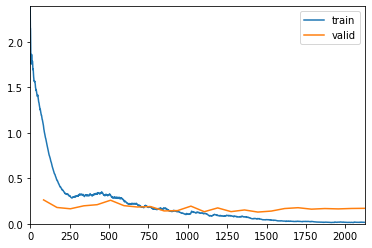

########################################



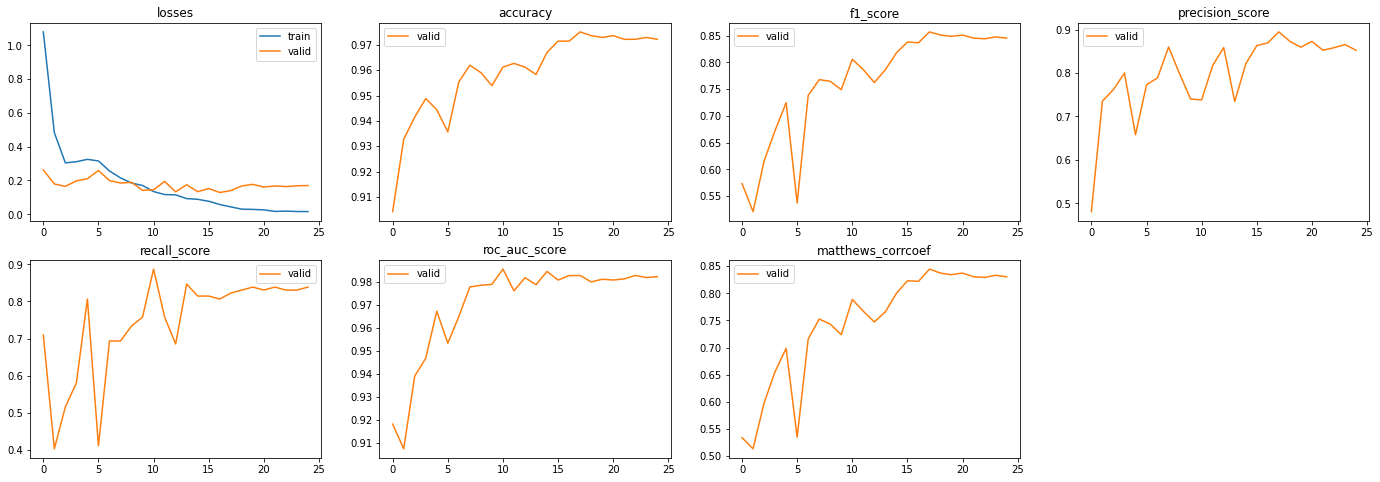

########################################


Training a resnet18 model with random state 2 when sampling validation data. 25 epochs:
Creating a dataloader for the dataset CHEMBL1978_cl
Settings: oversample=False, random_state=2, test_size=0.2
Settings: batch size=64, batch_tfms=None, item_tfms=None, image size=None
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f696c8ca430> ###
	 pretrained=True, epochs=25

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.014454397559165954

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.165432,0.348616,0.855889,0.477454,0.355731,0.725806,0.896641,0.439765,00:21
1,0.569750,0.175408,0.942209,0.625592,0.758621,0.532258,0.912692,0.606311,00:21
2,0.334315,0.201833,0.930505,0.641509,0.602837,0.685484,0.918966,0.604734,00:21
3,0.300191,0.206145,0.936357,0.553846,0.760563,0.435484,0.937300,0.545920,00:21
4,0.295791,0.329329,0.940746,0.584615,0.802817,0.459677,0.900611,0.580356,00:22
5,0.291361,0.251893,0.949525,0.706383,0.747748,0.669355,0.947723,0.680110,00:22
6,0.254038,0.314370,0.945867,0.640777,0.804878,0.532258,0.912387,0.628171,00:21
7,0.204231,0.225910,0.950988,0.728745,0.731707,0.725806,0.959106,0.701812,00:22
8,0.193322,0.194563,0.955377,0.723982,0.824742,0.645161,0.958162,0.706353,00:22
9,0.153946,0.299797,0.934894,0.696246,0.603550,0.822581,0.949131,0.670686,00:22


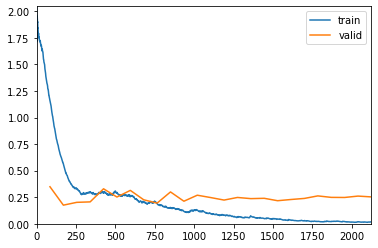

########################################



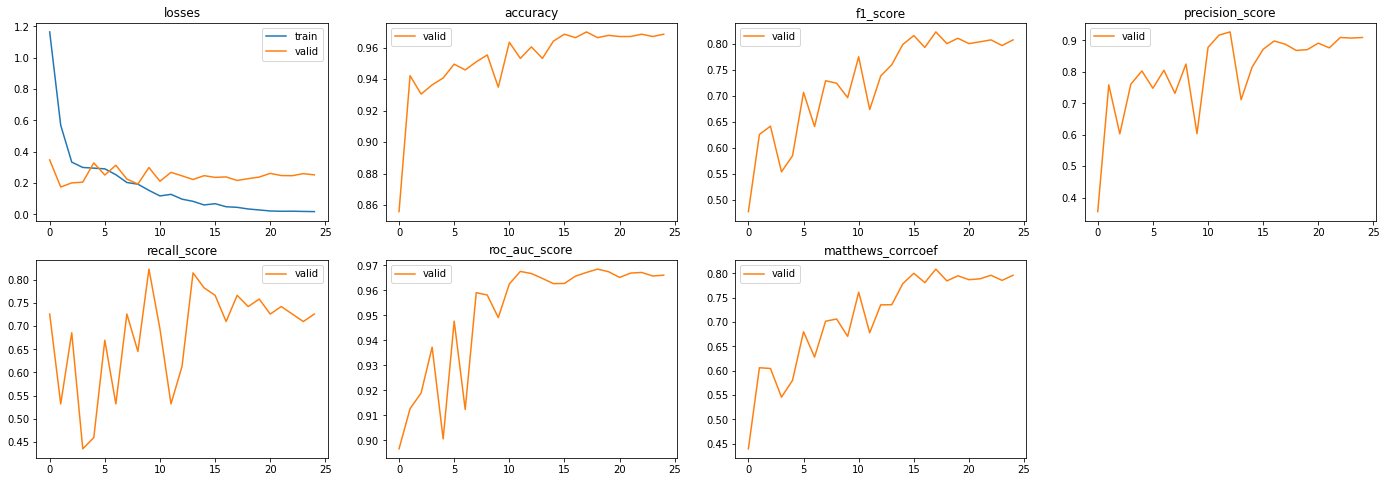

########################################


Training a resnet18 model with random state 3 when sampling validation data. 25 epochs:
Creating a dataloader for the dataset CHEMBL1978_cl
Settings: oversample=False, random_state=3, test_size=0.2
Settings: batch size=64, batch_tfms=None, item_tfms=None, image size=None
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f696c8ca430> ###
	 pretrained=True, epochs=25

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.02089296132326126

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.024597,0.238021,0.910022,0.525097,0.503704,0.548387,0.895161,0.476023,00:21
1,0.455190,0.178743,0.936357,0.575610,0.728395,0.475806,0.915533,0.557251,00:21
2,0.330289,0.211836,0.932699,0.505376,0.758065,0.379032,0.936042,0.506488,00:21
3,0.378310,0.218636,0.926847,0.632353,0.581081,0.693548,0.938884,0.594944,00:21
4,0.355998,0.330366,0.948793,0.619565,0.950000,0.459677,0.965426,0.641062,00:21
5,0.307620,0.221711,0.953182,0.711712,0.806122,0.637097,0.954484,0.692247,00:21
6,0.272920,0.226819,0.957571,0.697917,0.985294,0.540323,0.971005,0.712678,00:22
7,0.211665,0.377662,0.927579,0.361290,0.903226,0.225806,0.949160,0.430955,00:22
8,0.195580,0.144010,0.963424,0.761905,0.930233,0.645161,0.977707,0.757407,00:22
9,0.174687,0.127843,0.967081,0.800000,0.891089,0.725806,0.982846,0.787158,00:22


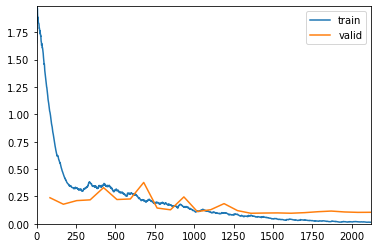

########################################



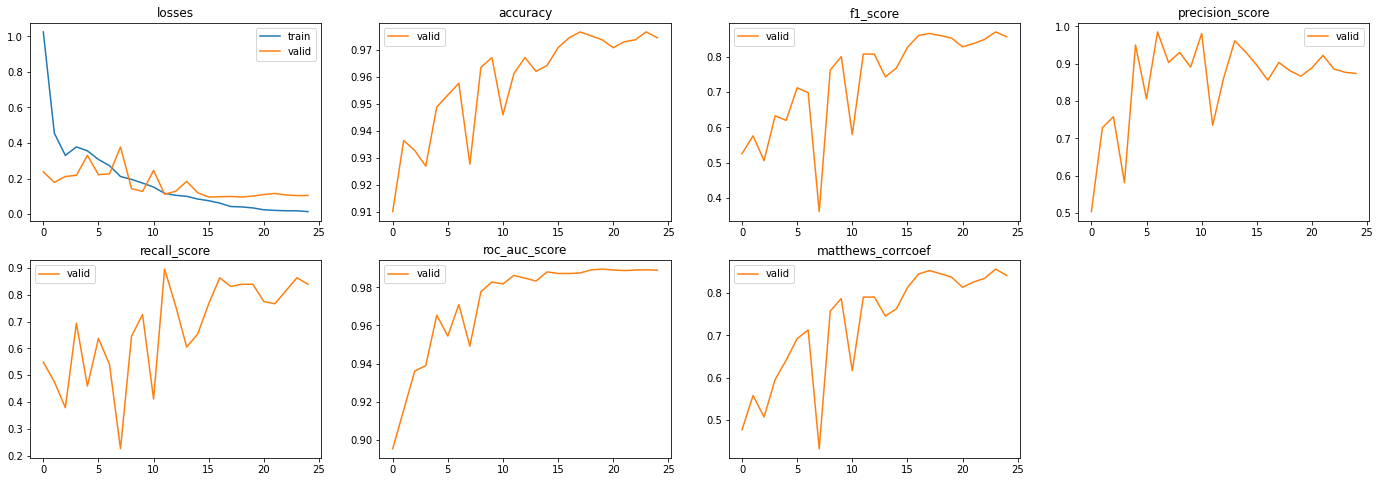

########################################


Training a resnet18 model with random state 42 when sampling validation data. 25 epochs:
Creating a dataloader for the dataset CHEMBL1978_cl
Settings: oversample=False, random_state=42, test_size=0.2
Settings: batch size=64, batch_tfms=None, item_tfms=None, image size=None
DONE
Training a model on the provided data

### Architecture: arch=<function resnet18 at 0x7f696c8ca430> ###
	 pretrained=True, epochs=25

### Regularization: weight decay=0.0002, droput rate=0.8 ### 

Finding a learning rate...


Using the base learning rate lr_min=0.017378008365631102

### Training the model... ### 



epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.047756,0.258118,0.905633,0.562712,0.485380,0.669355,0.898736,0.519624,00:21
1,0.472011,0.171397,0.938552,0.588235,0.750000,0.483871,0.914502,0.572341,00:21
2,0.313495,0.149715,0.937820,0.550265,0.800000,0.419355,0.955486,0.551820,00:21
3,0.345117,0.259013,0.929773,0.619048,0.609375,0.629032,0.912530,0.580469,00:21
4,0.325907,0.283363,0.950988,0.656410,0.901408,0.516129,0.961857,0.660706,00:21
5,0.322615,0.152124,0.956840,0.764940,0.755906,0.774194,0.970045,0.741247,00:21
6,0.264676,0.182499,0.960497,0.758929,0.850000,0.685484,0.966827,0.742748,00:21
7,0.221276,0.140841,0.960497,0.758929,0.850000,0.685484,0.975268,0.742748,00:22
8,0.189397,0.181117,0.955377,0.746888,0.769231,0.725806,0.961351,0.722809,00:22
9,0.161389,0.124276,0.961229,0.757991,0.873684,0.669355,0.984338,0.745055,00:22


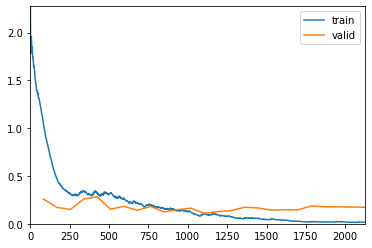

########################################



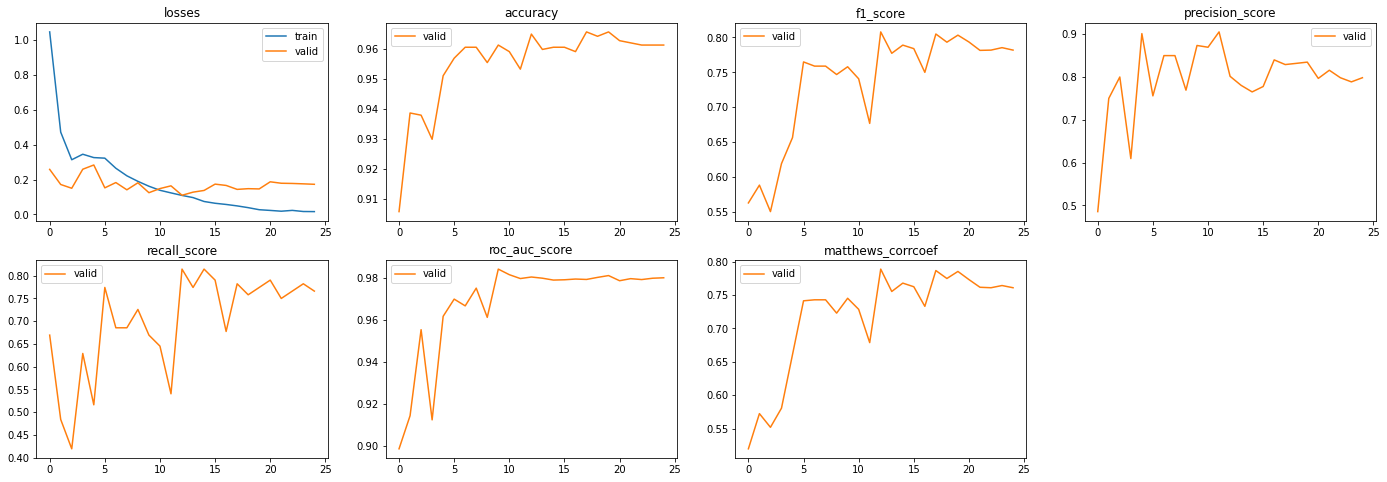

########################################




In [90]:
epochs=15
models = []
for random_state in [1,2,3,42]:
    print(f"Training a resnet18 model with random state {random_state} when sampling validation data. {epochs} epochs:")
    dl = get_dataloader(ds[0], oversample=False, random_state=random_state, test_size=0.2, bs=64, batch_tfms=None, item_tfms=None, size=None)
    learn = train_model(dl, epochs=epochs)
    models.append(learn)
    print("#"*40)
    print()
    learn.recorder.plot_metrics()
    print("#"*40)
    print()
    print()

> We observe quite some variation, indicating that k-fold cross-validation would be very useful.

# Extra: Create a pre-text task and fine tune from that

> Use a model pre-trained on one of the task as the starting point for the others.